# Feature Engineering

**Feature Engineering** is the process of transforming raw data into features that better represent the underlying problem to predictive models, leading to improved model performance. It is a key step in the machine learning pipeline and often has a greater impact on model accuracy than the choice of model itself.


### 🔧 Key Steps in Feature Engineering

1. **Understanding the Data**

   * Explore and visualize data to identify patterns, trends, outliers.
   * Understand the domain and the meaning of each feature.

2. **Handling Missing Values**

   * Techniques: Imputation (mean/median/mode, KNN), deletion, or special category ("Unknown").

3. **Encoding Categorical Variables**

   * Label Encoding
   * One-Hot Encoding
   * Target Encoding / Mean Encoding
   * Frequency Encoding

4. **Creating New Features**

   * Date & time features: Extract day, month, year, weekday, hour.
   * Text features: Word counts, sentiment scores, TF-IDF, embeddings.
   * Interaction features: Combine two or more features.
   * Aggregations: Mean, sum, count by group.

5. **Scaling/Normalization**

   * StandardScaler (Z-score normalization)
   * MinMaxScaler
   * RobustScaler (for outliers)

6. **Feature Selection**

   * Filter Methods: Correlation, Chi-square.
   * Wrapper Methods: Recursive Feature Elimination (RFE).
   * Embedded Methods: Lasso, decision trees, feature importances.

7. **Dimensionality Reduction**

   * PCA (Principal Component Analysis)
   * t-SNE, UMAP (for visualization)
   * Autoencoders

8. **Dealing with Imbalanced Data**

   * SMOTE (Synthetic Minority Over-sampling Technique)
   * Undersampling
   * Creating ratio-based features

## Imports

In [1]:
# data manupulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

# stats
import statsmodels.api as sm
from scipy.stats import boxcox # this can't handle negative values
from scipy.stats import yeojohnson # this ia extention to boxcox

# encoder and scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer

# utility
import os
from typing import List
import string
import time
import re
import ast
import warnings
warnings.filterwarnings('ignore')

## Read Clean Data

In [2]:
DATA_DIR = os.path.join("data", "heart_stroke_clean_data.csv")
df = pd.read_csv(DATA_DIR)

In [3]:
df.head()

,Id,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke
0,9046,male,67.0,0,1,yes,private,urban,228.69,36.6,formerly_smoked,1
1,51676,female,61.0,0,0,yes,self_employed,rural,202.21,-1.0,never_smoked,1
2,31112,male,80.0,0,1,yes,private,rural,105.92,32.5,never_smoked,1
3,60182,female,49.0,0,0,yes,private,urban,171.23,34.4,smokes,1
4,1665,female,79.0,1,0,yes,self_employed,rural,174.12,24.0,never_smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
TARGET_COL = ["Stroke"]
ID_COL = ["Id"]
TEXT_FEATURES = [""]
CAT_FEATURES = [col for col in df.columns if df[col].dtype == "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]
NUM_FEATURES = [col for col in df.columns if df[col].dtype != "O" if col not in TARGET_COL+ID_COL+TEXT_FEATURES]
DROP_COLUMNS = [] # add columns which we want to drop at end 

In [6]:
TARGET_DATA = df[TARGET_COL].copy()
ID_DATA = df[ID_COL].copy()

In [7]:
print("id column: ", ID_COL)
print("target column: ", TARGET_COL)
print("categorical columns: ", CAT_FEATURES)
print("numerical columns: ", NUM_FEATURES)
print("text features: ", TEXT_FEATURES)

id column:  ['Id']
target column:  ['Stroke']
categorical columns:  ['Gender', 'Ever_married', 'Work_type', 'Residence_type', 'Smoking_status']
numerical columns:  ['Age', 'Hypertension', 'Heart_disease', 'Avg_glucose_level', 'Bmi']
text features:  ['']


## Miscellaneous Functions

In [8]:
class DataEncoding:

    def __init__(self, clean_df: pd.DataFrame):
        self.original_df = clean_df.copy()
        self.df = clean_df.copy() # here will perform our encodings & transformations
        self.trans_tech = ["Logarithmic", "Logarithmic_10", "Exponential", "Exponential_2", "Power", "Square", "Cubic"]
        self.scale_tech = ["Normal_l1", "Normal_l2", "MaxAbcScaler", "Robust", "MinMax", "Standard"]

    # label encoding
    def lable_encode(self, input_col:str, output_col:str):
        """
        label encodes the passed column from dataframe
        and adds encoded data to dataframe under new columns
        name reffred to variable `output_col`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col (str): column name for encoded data.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col `string` is empty.

        Example:
            >>> 
        """
        label_encode = LabelEncoder()
        label_encode.fit(self.df[input_col])
        self.df[output_col] = label_encode.transform(self.df[input_col])
        print(f"Applied Label Encoded : {input_col} --> {output_col}")

    # ordinal encoding
    def ordinal_encode(self, input_col:str, output_col:str, categories=List[str]) -> None:
        """
        ordinally encodes the passed column using categories from dataframe
        and adds encoded data to dataframe under new columns
        name reffred to variable `output_col`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col (str): column name for encoded data.
            cotegories (list): list of all unique values from input col.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col `string` is empty.

        Example:
            >>> 
        """
        if len(categories) > 0:
            ordinal_encod = OrdinalEncoder(categories=[categories])
        else:
            ordinal_encod = OrdinalEncoder(categories=[self.df[input_col].unique().tolist()])
        self.df[output_col] = ordinal_encod.fit_transform(self.df[[input_col]])
        print(f"Applied Ordinal Encoded : {input_col} --> {output_col}")

    # onehot encoding
    def onehot_encode(self, input_col:str, output_col_initials:str) -> None:
        """
        applies one hot encoding on passed `input_col`
        an renames all onehot encoded columns with 
        initials with `output_col_initials`.

        Args:
            input_col (str): column name that exists in dataframe.
            output_col_initials (str): column name for encoded data.

        Returns:
            None

        Raises:
            ValueError: If the input_col `string` is empty.
            ValueError: If the output_col_initials `string` is empty.

        Example:
            >>> 
        """
        if len(output_col_initials) == 0:
            output_col_initials = input_col
        # initalized encoder
        onehot_encode = OneHotEncoder()
        # applying encoding
        onehot_encoded = onehot_encode.fit_transform(self.df[[input_col]]).toarray()

        # Create a DataFrame for the encoded data
        df_encoded = pd.DataFrame(onehot_encoded, columns=onehot_encode.get_feature_names_out([output_col_initials]))

        # Concatenate with original DataFrame
        self.df = pd.concat([self.df, df_encoded], axis=1)
        print(f"OneHotEncoder Applied on : {input_col}")

    def map_custom_encoding(self, input_col:str, output_col:str, encoding:dict) -> None:
        # Apply custom encoding using map
        self.df[output_col] = self.df[input_col].map(encoding)
        print(f"Applied Custom Encoded : {input_col} --> {output_col}")

    def feature_tranformation(self, input_col:str, type_of_trans: str):
        if type_of_trans == "Logarithmic":
            self.df[input_col+"_Log"] = np.log(self.df[input_col])
        elif type_of_trans == "Logarithmic_10": # base 10
            self.df[input_col+"_Log_10"] = np.log10(self.df[input_col])
        elif type_of_trans == "Exponential":
            self.df[input_col+"_Exp"] = np.exp(self.df[input_col])
        elif type_of_trans == "Exponential_2": # power 2
            self.df[input_col+"_Exp_2"] = np.exp2(self.df[input_col])
        elif type_of_trans == "Power": # removed boxcox
            transformed_data, _ = yeojohnson(self.df[input_col])
            self.df[input_col+"_Power"] = transformed_data
        elif type_of_trans == "Square":
            self.df[input_col+"_Squr"] = np.power(self.df[input_col], 2)
        elif type_of_trans == "Cubic":
            self.df[input_col+"_Cube"] = np.power(self.df[input_col], 3)
        else:
            print(f"No transformation applied: {input_col}")
            # self.df[input_col] = self.df[input_col]

    def feature_scaling(self, input_col:str, type_of_scale:str):
        if type_of_scale == "Normal_l1":
            scaler = Normalizer(norm='l1')
            self.df[input_col+"_Norm_l1"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Normal_l2":
            scaler = Normalizer(norm='l2')
            self.df[input_col+"_Norm_l2"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "MaxAbcScaler":
            scaler = MaxAbsScaler()
            self.df[input_col+"_MaxAbs"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Robust":
            scaler = RobustScaler()
            self.df[input_col+"_Robust"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "MinMax":
            scaler = MinMaxScaler()
            self.df[input_col+"_MinMax"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))

        elif type_of_scale == "Standard":
            scaler = StandardScaler()
            self.df[input_col+"_Standard"] = scaler.fit_transform(np.array(self.df[input_col]).reshape(-1, 1))
        print(f"Applied: {type_of_scale} >>> {input_col}")

    def transform_with_all_technique(self, input_col:str):
        for tech in self.trans_tech:
            self.feature_tranformation(input_col, tech)
            print(f"Transformed {input_col} with : {tech}")

    def scaling_with_all_technique(self, input_col:str):
        for tech in self.scale_tech:
            self.feature_scaling(input_col, tech)
            print(f"Scaled {input_col} with : {tech}")   

    def test_all_combinations(self, feature: str, plan: dict = {'scale':[], 'transform':[]}):
        
        # step1 : scaling & transformation
        if plan == ['scale', 'transform']:

            # apply all scaling 
            for scaling_technique in plan['scale']:

                self.feature_scaling(feature, scaling_technique)

            # remove -inf , +inf, np.nan columns
            
            # apply all transformations

            # remove -inf , +inf, np.nan columns

            # plot each combinations plot row - > transformation & column -> scaling
        else:
            pass
            # apply all transformations

            # remove -inf , +inf, np.nan columns

            # apply all scaling

            # plot each combinations plot row - > transformation & column -> scaling

    def plot_all_combinations(self, data: pd.DataFrame):
        # Set up the matplotlib figure
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))  # 6x7 grid

        # Flatten the axes array for easy iteration
        axes = axes.flatten()

        # Loop through each feature and plot KDE
        for i, ax in enumerate(axes):
            if i < data.shape[1]:  # Ensure we only plot existing features
                sns.kdeplot(data.iloc[:, i], ax=ax, fill=True)
                ax.set_title(data.columns[i])  # Set the title to the column name
            else:
                ax.axis('off')  # Turn off unused subplots

        # Adjust layout
        plt.tight_layout()
        plt.show()            
        

## Handeling Categorical Feature

In [9]:
encode_obj = DataEncoding(df[CAT_FEATURES])

In [10]:
encode_obj.df.head()

,Gender,Ever_married,Work_type,Residence_type,Smoking_status
0,male,yes,private,urban,formerly_smoked
1,female,yes,self_employed,rural,never_smoked
2,male,yes,private,rural,never_smoked
3,female,yes,private,urban,smokes
4,female,yes,self_employed,rural,never_smoked


In [11]:
CAT_FEATURES

['Gender', 'Ever_married', 'Work_type', 'Residence_type', 'Smoking_status']

### **Gender**

In [12]:
encode_obj.lable_encode("Gender", "Gender_encode")

Applied Label Encoded : Gender --> Gender_encode


### **Ever_married**

In [13]:
encode_obj.lable_encode("Ever_married", "Ever_married_encode")

Applied Label Encoded : Ever_married --> Ever_married_encode


### **Work_type**

In [14]:
encode_obj.lable_encode("Work_type", "Work_type_encode")

Applied Label Encoded : Work_type --> Work_type_encode


In [15]:
encode_obj.onehot_encode("Work_type", "Work_type")

OneHotEncoder Applied on : Work_type


### **Residence_type**

In [16]:
encode_obj.lable_encode("Residence_type", "Residence_type_encode")

Applied Label Encoded : Residence_type --> Residence_type_encode


### **Smoking_status**

In [17]:
encode_obj.lable_encode("Smoking_status", "Smoking_status_encode")

Applied Label Encoded : Smoking_status --> Smoking_status_encode


In [18]:
encode_obj.onehot_encode("Smoking_status", "Smoking_status")

OneHotEncoder Applied on : Smoking_status


In [19]:
encode_obj.df.head()

,Gender,Ever_married,Work_type,Residence_type,Smoking_status,Gender_encode,Ever_married_encode,Work_type_encode,Work_type_children,Work_type_govt_job,Work_type_never_worked,Work_type_private,Work_type_self_employed,Residence_type_encode,Smoking_status_encode,Smoking_status_formerly_smoked,Smoking_status_never_smoked,Smoking_status_smokes,Smoking_status_unknown
0,male,yes,private,urban,formerly_smoked,1,1,3,0.0,0.0,0.0,1.0,0.0,1,0,1.0,0.0,0.0,0.0
1,female,yes,self_employed,rural,never_smoked,0,1,4,0.0,0.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0
2,male,yes,private,rural,never_smoked,1,1,3,0.0,0.0,0.0,1.0,0.0,0,1,0.0,1.0,0.0,0.0
3,female,yes,private,urban,smokes,0,1,3,0.0,0.0,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0
4,female,yes,self_employed,rural,never_smoked,0,1,4,0.0,0.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0


### Drop Unwanted Columns

In [20]:
DROP_COLUMNS = ['Gender', 'Ever_married','Work_type', 'Residence_type', 'Smoking_status']
encode_obj.df.drop(DROP_COLUMNS, axis=1, inplace=True)

In [21]:
encode_obj.df.head()

,Gender_encode,Ever_married_encode,Work_type_encode,Work_type_children,Work_type_govt_job,Work_type_never_worked,Work_type_private,Work_type_self_employed,Residence_type_encode,Smoking_status_encode,Smoking_status_formerly_smoked,Smoking_status_never_smoked,Smoking_status_smokes,Smoking_status_unknown
0,1,1,3,0.0,0.0,0.0,1.0,0.0,1,0,1.0,0.0,0.0,0.0
1,0,1,4,0.0,0.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0
2,1,1,3,0.0,0.0,0.0,1.0,0.0,0,1,0.0,1.0,0.0,0.0
3,0,1,3,0.0,0.0,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0
4,0,1,4,0.0,0.0,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0


## Handeling Numerical Feature

In [22]:
def comparision_plot(df:pd.DataFrame, input_col:str, compare_col:str) -> None:
    sns.kdeplot(data=df, x=input_col, alpha=0.5,  fill=True, linewidth=0, label=input_col, common_norm=True)
    sns.kdeplot(data=df, x=compare_col, alpha=0.5,  fill=True, linewidth=0, label=compare_col, common_norm=True)
    plt.legend()
    plt.show()

In [23]:
NUM_FEATURES

['Age', 'Hypertension', 'Heart_disease', 'Avg_glucose_level', 'Bmi']

### **Age**

Transformed Age with : Logarithmic
Transformed Age with : Logarithmic_10
Transformed Age with : Exponential
Transformed Age with : Exponential_2
Transformed Age with : Power
Transformed Age with : Square
Transformed Age with : Cubic


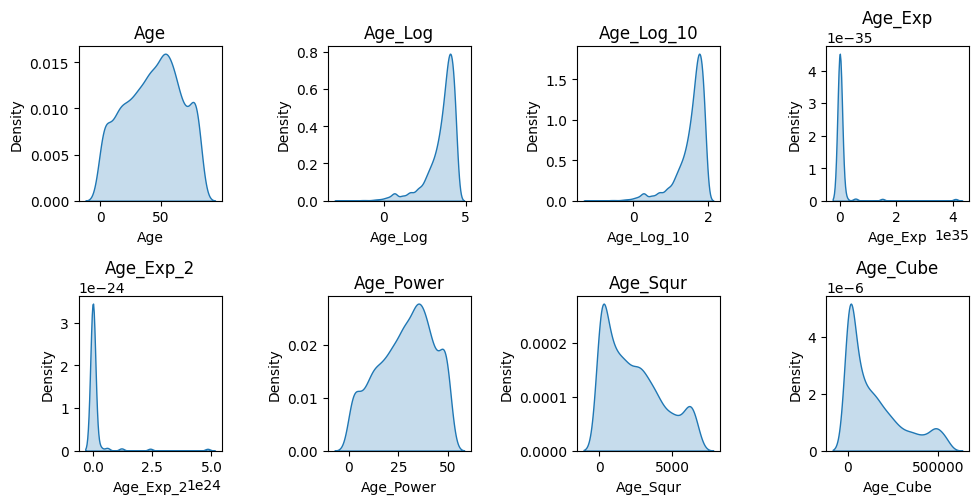

In [24]:
# loading data in encoding object
trans_age = DataEncoding(df[["Age"]])

# performing all scaline
trans_age.transform_with_all_technique("Age")

trans_age.plot_all_combinations(trans_age.df)

In [25]:
trans_age.df.columns

Index(['Age', 'Age_Log', 'Age_Log_10', 'Age_Exp', 'Age_Exp_2', 'Age_Power',
       'Age_Squr', 'Age_Cube'],
      dtype='object')

In [26]:
# fig = ff.create_distplot(data, columns, bin_size=.25, show_hist=False)
# fig.show()

#### Drop Unwanted Columns

In [27]:
DROP_COLUMNS = ['Age_Log', 'Age_Log_10', 'Age_Exp', 'Age_Exp_2', 'Age_Squr', 'Age_Cube']

In [28]:
trans_age.df.drop(DROP_COLUMNS, axis=1, inplace=True)

### **Avg_glucose_level**

Transformed Avg_glucose_level with : Logarithmic
Transformed Avg_glucose_level with : Logarithmic_10
Transformed Avg_glucose_level with : Exponential
Transformed Avg_glucose_level with : Exponential_2
Transformed Avg_glucose_level with : Power
Transformed Avg_glucose_level with : Square
Transformed Avg_glucose_level with : Cubic


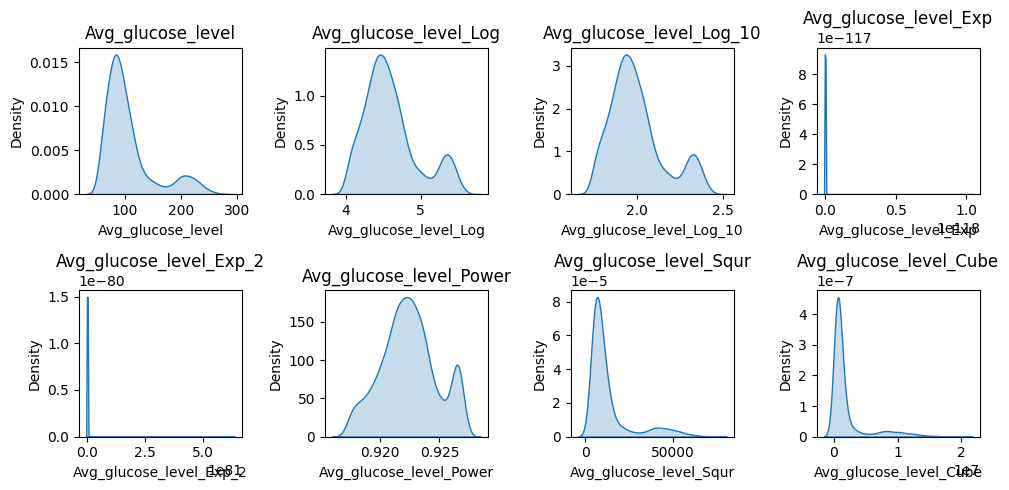

In [29]:
# loading data in encoding object
trans_avg_gl = DataEncoding(df[["Avg_glucose_level"]])

# performing all scaline
trans_avg_gl.transform_with_all_technique("Avg_glucose_level")

trans_avg_gl.plot_all_combinations(trans_avg_gl.df)

In [30]:
trans_avg_gl.df.columns

Index(['Avg_glucose_level', 'Avg_glucose_level_Log',
       'Avg_glucose_level_Log_10', 'Avg_glucose_level_Exp',
       'Avg_glucose_level_Exp_2', 'Avg_glucose_level_Power',
       'Avg_glucose_level_Squr', 'Avg_glucose_level_Cube'],
      dtype='object')

#### Drop Unwanted Columns

In [31]:
DROP_COLUMNS = ['Avg_glucose_level', 'Avg_glucose_level_Log', 'Avg_glucose_level_Log_10', 'Avg_glucose_level_Exp',
                                'Avg_glucose_level_Exp_2', 'Avg_glucose_level_Squr', 'Avg_glucose_level_Cube']

In [32]:
trans_avg_gl.df.drop(DROP_COLUMNS, axis=1, inplace=True)

### **Bmi**

- transformation only work after handling missing values

Transformed Bmi with : Logarithmic
Transformed Bmi with : Logarithmic_10
Transformed Bmi with : Exponential
Transformed Bmi with : Exponential_2
Transformed Bmi with : Power
Transformed Bmi with : Square
Transformed Bmi with : Cubic


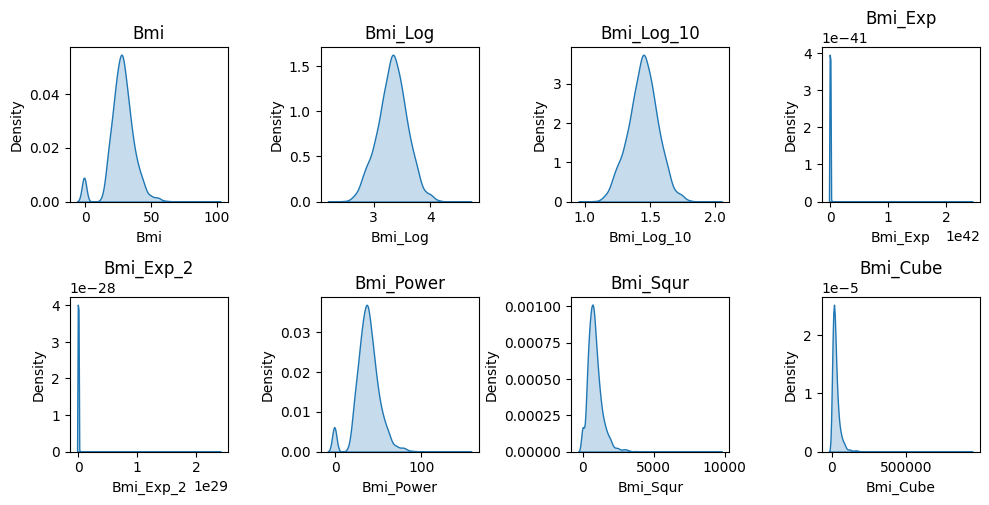

In [33]:
# loading data in encoding object
trans_bmi = DataEncoding(df[["Bmi"]])

# performing all scaline
trans_bmi.transform_with_all_technique("Bmi")

trans_bmi.plot_all_combinations(trans_bmi.df)

In [34]:
# trans_bmi.df.columns

#### Drop Unwanted Columns

In [35]:
# DROP_COLUMNS = ['Bmi', 'Bmi_Exp', 'Bmi_Exp_2', 'Bmi_Power', 'Bmi_Squr', 'Bmi_Cube']

In [36]:
# trans_bmi.df.drop(DROP_COLUMNS, axis=1, inplace=True)

## Handeling Date Feature

In [37]:
# don't have date related columns

In [38]:
# DROP_COLUMNS = DROP_COLUMNS + []

## Handeling Text Feature

In [39]:
# don't have text related columns

In [40]:
# DROP_COLUMNS = DROP_COLUMNS + []

## Merge & Drop Unwanted Columns

In [41]:
DF_LEVEL_1 = pd.concat(
    [
        ID_DATA,
        trans_age.df,
        trans_avg_gl.df,
        trans_bmi.df,
        encode_obj.df,
        TARGET_DATA,
    ],
    axis=1
)

In [42]:
DF_LEVEL_1.head()

,Id,Age,Age_Power,Avg_glucose_level_Power,Bmi,Bmi_Log,Bmi_Log_10,Bmi_Exp,Bmi_Exp_2,Bmi_Power,...,Work_type_never_worked,Work_type_private,Work_type_self_employed,Residence_type_encode,Smoking_status_encode,Smoking_status_formerly_smoked,Smoking_status_never_smoked,Smoking_status_smokes,Smoking_status_unknown,Stroke
0,9046,67.0,42.663301,0.926756,36.6,3.600048,1.563481,7.855576e+15,1.041592e+11,50.730499,...,0.0,1.0,0.0,1,0,1.0,0.0,0.0,0.0,1
1,51676,61.0,39.315669,0.926379,-1.0,NaN,NaN,3.678794e-01,5.000000e-01,-0.955627,...,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0,1
2,31112,80.0,49.780537,0.923337,32.5,3.481240,1.511883,1.301879e+14,6.074001e+09,44.477741,...,0.0,1.0,0.0,0,1,0.0,1.0,0.0,0.0,1
3,60182,49.0,32.477743,0.925784,34.4,3.538057,1.536558,8.704226e+14,2.266897e+10,47.364744,...,0.0,1.0,0.0,1,2,0.0,0.0,1.0,0.0,1
4,1665,79.0,49.239063,0.925848,24.0,3.178054,1.380211,2.648912e+10,1.677722e+07,31.814112,...,0.0,0.0,1.0,0,1,0.0,1.0,0.0,0.0,1


## Save Data 

In [43]:
DF_LEVEL_1.to_csv(os.path.join("data", "heart_stroke_feature_engineered_level_1.csv"), index=False)

## Handeling Missing Values

In [52]:
DF_LEVEL_2 = DF_LEVEL_1.copy()

In [53]:
DF_LEVEL_2.isna().sum()

Id                                  0
Age                                 0
Age_Power                           0
Avg_glucose_level_Power             0
Bmi                                 0
Bmi_Log                           201
Bmi_Log_10                        201
Bmi_Exp                             0
Bmi_Exp_2                           0
Bmi_Power                           0
Bmi_Squr                            0
Bmi_Cube                            0
Gender_encode                       0
Ever_married_encode                 0
Work_type_encode                    0
Work_type_children                  0
Work_type_govt_job                  0
Work_type_never_worked              0
Work_type_private                   0
Work_type_self_employed             0
Residence_type_encode               0
Smoking_status_encode               0
Smoking_status_formerly_smoked      0
Smoking_status_never_smoked         0
Smoking_status_smokes               0
Smoking_status_unknown              0
Stroke      

#### Constant Imputation

In [ ]:
DF_LEVEL_2['Bmi_Imputed_0'] = DF_LEVEL_2['Bmi'].replace(-1, 0)

#### Mean Imputation

In [ ]:
DF_LEVEL_2['Bmi_Imputed_mean'] = DF_LEVEL_2['Bmi'].replace(-1, DF_LEVEL_1['Bmi'].mean())

#### Median Imputation

In [ ]:
DF_LEVEL_2['Bmi_Imputed_median'] = DF_LEVEL_2['Bmi'].replace(-1, DF_LEVEL_1['Bmi'].median())

#### Mode Imputation

In [ ]:
DF_LEVEL_2['Bmi_Imputed_mode'] = DF_LEVEL_2['Bmi'].replace(-1, DF_LEVEL_1['Bmi'].mode()[0])

#### KNN Imputation

In [ ]:
# yet to implement

## Save Data 

In [ ]:
DF_LEVEL_2.to_csv(os.path.join("data", "heart_stroke_feature_engineered_level_2.csv"), index=False)

## Feature Extraction

## Scaling & Transformation

## Drop Unwanted Columns

In [45]:
# df.drop(DROP_COLUMNS, axis=1, inplace=True)

## Save Data 

In [ ]:
# DF_LEVEL_2.to_csv(os.path.join("data", "heart_stroke_feature_engineered_level_3.csv"), index=False)